# Quality control notebook to look at mixing in salinity coordinates. 
Theory copied from ```diahaline_mixing_tadvection.ipynb```. See there for more details. Just check any derivatives or integrals are computed directly 
### The volume-integrated mixing in a 3D control volume with with salinities $s>S$ may be calculated as
$M(s) = \int_{V(s)} \chi^s \, dV$, $\chi^s = 2 \kappa_V \left(\frac{\partial s}{\partial z} \right)^2 \, ,$
> - where $V(s)$ is a volume including all salinities $s \leq S$
> - $\kappa_v$ is the vertical salinity diffusivity 

### The mixing per salinity class may be calculated as 

$m(s) = \frac{\partial M}{\partial s} \,$.

The integrated diahaline diffusive salt flux is directly proportional to the $m(s)$: 

$J_{dia} = -\frac{1}{2} m(s)$.

By differentiating in salinity coordinates again, we obtain an expression for the integrated diahaline volume transport 

$Q_{dia} = \frac{1}{2} \frac{\partial m(s)}{\partial s}$.
 
So, once we have an expression for the volume-integrated mixing we should be able to calculate each of these quantities with a simple ```.diff()```. 

### Test out MPDATA only in this notebook, turn analysis into a script. We want to do this for each advection scheme to try to relate this to differences in isohaline position. 

Compute these quantities for $\mathcal{M}_{num}$, $\mathcal{M}_{phy}$, and $\mathcal{M}_{tot}$

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime
import glob
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from datetime import timedelta

In [2]:
def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    return ds1, grid1

paths = '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_mpdata_uwind_osc_1/shelf_dx_500_mpdata_uwind_osc_1_avg.nc'
# paths = '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_0_f_43N/shelf_dx_500_uwind_0_f_43N_open_avg.nc'
ds, grid = open_roms(paths)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


### Open shelfstrat 0.1 Pa model output and compute volume-integrated physical, numerical, and total mixing

In [3]:
xislice = slice(1,-1) #Exclude boundary points bc periodic BC
etaslice = slice(1,100) # Initially stratified region
tslice = slice(156,337) # Days 7.5-15 

salt = ds.salt.isel(ocean_time = tslice, eta_rho = etaslice,xi_rho = xislice)
dv = ds.dV.isel(ocean_time = tslice, eta_rho = etaslice,xi_rho = xislice)

akr = grid.interp(ds.AKr,'Z')
mphy = (akr*ds.dV).isel(ocean_time = tslice, eta_rho = etaslice,xi_rho = xislice)
mnum = (ds.dye_03*ds.dV).isel(ocean_time = tslice, eta_rho = etaslice,xi_rho = xislice)
mtot = ((ds.dye_03+akr)*ds.dV).isel(ocean_time = tslice, eta_rho = etaslice,xi_rho = xislice)

### Compute the histograms and plot the results 

In [4]:
sbins = np.linspace(27,35,51)

Mnum_s = histogram(salt, bins = [sbins], weights = mnum).load()
Mphy_s = histogram(salt, bins = [sbins], weights = mphy).load()
Mtot_s = histogram(salt, bins = [sbins], weights = mtot).load()

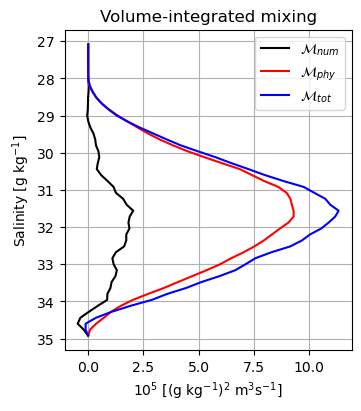

In [5]:
fig, ax = plt.subplots(1, figsize = (3.5,4), sharex = True, sharey= True, constrained_layout = True)

(Mnum_s/10**5).plot(ax = ax, y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(Mphy_s/10**5).plot(ax = ax, y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(Mtot_s/10**5).plot(ax = ax, y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax.set_title(r'Volume-integrated mixing')
ax.set_xlabel(r'$10^5$ [(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax.grid(which = 'both')
ax.set_ylabel('Salinity [g kg$^{-1}$]')
ax.legend()
plt.gca().invert_yaxis()

## Compute the mixing per salinity class $\frac{\partial \mathcal{M}}{\partial s}$.
Check the calculations by discreetly reconstruncting the integral with a .cumsum()

In [6]:
dsalt = (Mnum_s.salt_bin[1]-Mnum_s.salt_bin[0]).values
mnum_s = Mnum_s.diff('salt_bin')/dsalt
mphy_s = Mphy_s.diff('salt_bin')/dsalt
mtot_s = Mtot_s.diff('salt_bin')/dsalt

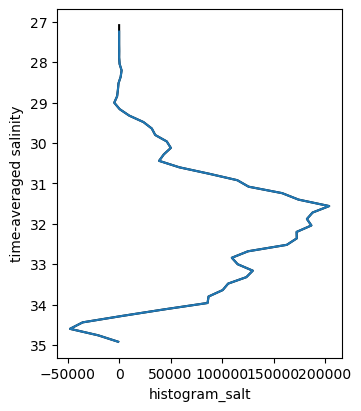

In [7]:
fig, ax = plt.subplots(1, figsize = (3.5,4), sharex = True, sharey= True, constrained_layout = True)

(Mnum_s).plot(ax = ax, y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(mnum_s*dsalt).cumsum().plot(y = 'salt_bin')
plt.gca().invert_yaxis()

### Great, reconstructing the integral discreetly works as expected, we just lose the first salinity bin

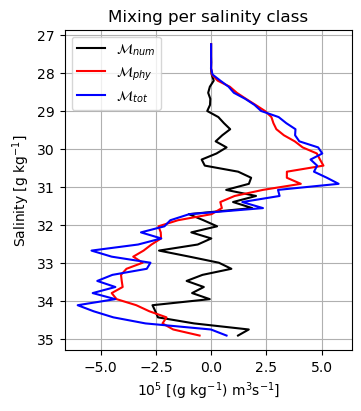

In [8]:
fig, ax = plt.subplots(1, figsize = (3.5,4), sharex = True, sharey= True, constrained_layout = True)

(mnum_s/10**5).plot(ax = ax, y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(mphy_s/10**5).plot(ax = ax, y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(mtot_s/10**5).plot(ax = ax, y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax.set_title(r'Mixing per salinity class')
ax.set_xlabel(r'$10^5$ [(g kg$^{-1}$) m$^3$s$^{-1}$]')
ax.grid(which = 'both')
ax.set_ylabel('Salinity [g kg$^{-1}$]')
ax.legend()
plt.gca().invert_yaxis()

### According to Walin (1977), and Burchard et al. (2021), the integrated diahaline diffusive salt flux is proportional to the integrated mixing per salinity class.
#### $J_{dia}(s) = -\frac{1}{2}m(s)$. 
### Hennel et al. (preprint to JGR: Oceans) derive that the integrated mixing per salinity class induces the integrated diahaline volume transport 
#### $Q_{dia}(s) = \frac{1}{2}\frac{\partial m(s)}{\partial s}$. 

In [9]:
Jdia_num = -0.5*(mnum_s)
Jdia_phy = -0.5*(mphy_s)
Jdia_tot = -0.5*(mtot_s)

Qdia_num = 0.5*(mnum_s.diff('salt_bin')/dsalt)
Qdia_phy = 0.5*(mphy_s.diff('salt_bin')/dsalt)
Qdia_tot = 0.5*(mtot_s.diff('salt_bin')/dsalt)

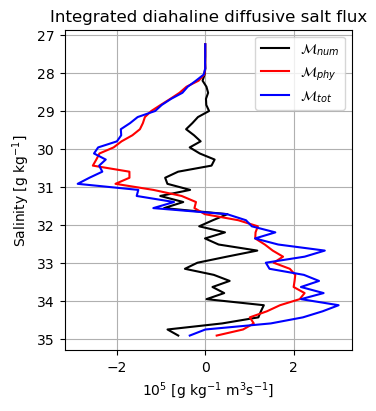

In [10]:
fig, ax = plt.subplots(1, figsize = (3.5,4), sharex = True, sharey= True, constrained_layout = True)

(Jdia_num/10**5).plot(ax = ax, y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(Jdia_phy/10**5).plot(ax = ax, y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(Jdia_tot/10**5).plot(ax = ax, y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax.set_title(r'Integrated diahaline diffusive salt flux')
ax.set_xlabel(r'$10^5$ [g kg$^{-1}$ m$^3$s$^{-1}$]')
ax.grid(which = 'both')
ax.set_ylabel('Salinity [g kg$^{-1}$]')
ax.legend()
plt.gca().invert_yaxis()

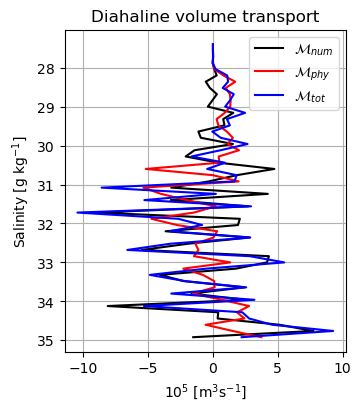

In [11]:
fig, ax = plt.subplots(1, figsize = (3.5,4), sharex = True, sharey= True, constrained_layout = True)

(Qdia_num/10**5).plot(ax = ax, y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(Qdia_phy/10**5).plot(ax = ax, y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(Qdia_tot/10**5).plot(ax = ax, y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax.set_title(r'Diahaline volume transport')
ax.set_xlabel(r'$10^5$ [m$^3$s$^{-1}$]')
ax.grid(which = 'both')
ax.set_ylabel('Salinity [g kg$^{-1}$]')
ax.legend()
plt.gca().invert_yaxis()